In [1]:
import os
os.getcwd()

'/root/autodl-tmp/Ensemble_oddeven/script'

In [2]:
batch_size=32
epochs = 5

In [3]:
import numpy as np
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset,TensorDataset
from torch import nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, accuracy_score
import torch.nn.functional as F
import tqdm
import math
from Model import *
from Myloader import *
from Training import *
from utils import *
from Myloader import *
import matplotlib.pyplot as plt


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
test_path = "../data/test"

In [6]:
# transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])

In [7]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

In [8]:

custom_dataset = CustomDataset(test_path, transform=transform)
data_loader = DataLoader(custom_dataset, batch_size=5, shuffle=True)

In [9]:
images_all, category_label, info_label, idx_info, even_num,_= next(iter(data_loader ))
print(len(images_all))
print(category_label)
print(info_label)
print(idx_info)
print(even_num)
print(images_all[0].shape)
print(info_label)


2
[tensor([2, 1, 2, 0, 2]), tensor([1, 2, 0, 2, 0])]
tensor([1, 0, 1, 0, 1])
tensor([1, 0, 1, 0, 1])
[tensor([2, 3, 2, 1, 2]), tensor([3, 2, 1, 2, 1])]
torch.Size([5, 1, 56, 56])
tensor([1, 0, 1, 0, 1])


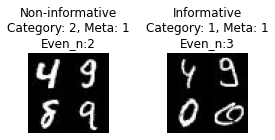

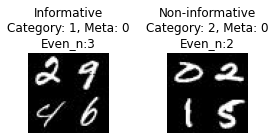

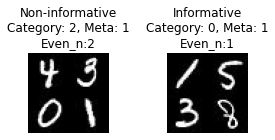

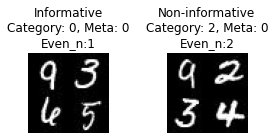

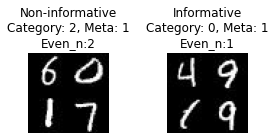

In [10]:

# 使用数据加载器中的数据来可视化图像和标签

# 调用函数显示图像和标签
show_images_labels(images_all, category_label, info_label, idx_info, even_num)


In [11]:
decision_model = CNN()
decision_model.load_state_dict(torch.load("../model/classifier.pt"))
decision_model.to(device)
decision_model.eval()

CNN(
  (features): ModuleList(
    (0): ConvBN2d(
      (conv): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (features): Sequential(
        (0): ReLU(inplace=True)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBN2d(
      (conv): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (features): Sequential(
        (0): ReLU(inplace=True)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvBN2d(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (features): Sequential(
        (0): ReLU(inplace=True)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): ConvBN2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1),

In [12]:
confidence_model = Confidence(6, 1)
confidence_model.load_state_dict(torch.load("../model/meta.pt"))
confidence_model.to(device)
confidence_model.eval()

Confidence(
  (fc1): Linear(in_features=6, out_features=1, bias=True)
)

In [19]:
data1 = images_all[0].to(device)
data2 = images_all[1].to(device)
label1 = category_label[0].to(device)
label2 = category_label[1].to(device)
label3 = info_label.to(device)

In [20]:
y_hat1 = decision_model(data1)
y_hat2 = decision_model(data2)
combined_output = torch.cat((y_hat1, y_hat2), dim=1)
y_hat3 = confidence_model(combined_output).squeeze()
y_hat3_sig = torch.sigmoid(y_hat3)